# Entrega Final - Grupo 12
***

*Introducción a la Minería de Datos - Otoño 2018*

Pedro Belmonte,
Jorge Fabry,
Víctor Garrido,
Pablo Ilabaca
***

# USAR LA SIGUIENTE URL PARA VER COMO FUNCIONA EL MARKDOWN. BORRAR ANTES DE ENTREGAR
https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed

# Motivación
***
La industria de los videojuegos es una de las más grandes industrias de entretenimiento a nivel mundial. Las mayores publicaciones se enfrentan codo a codo para conseguir el mayor éxito y con esto mayores ventas.

En esta industria, como en muchas otras, los críticos juegan un rol vital a la hora de definir la recepción que tendrá un juego. Casi siempre, los críticos reciben copias de juegos antes de que estos sean lanzados al público, por lo que tienen la primera palabra a la hora de publicitar si un juego es de calidad o no.

Dado esto, se da origen a un fenómeno en el que los críticos dan muy buena crítica a un juego, tal vez motivados por dinero o por quedar bien con los publicadores para seguir recibiendo acceso exclusivo a los juegos, y luego los usuarios dan un puntaje mucho menor, dejando una sensación de engaño y desencanto. A estos juegos con una gran diferencia de puntaje los llamaremos **fiascos**.

<img src="media/intro-ejemplos_de_fiascos.PNG" alt="Ejemplos de Fiascos" title="Puntaje de un par de fiascos en Metacritic" />

Interesa entonces utilizar las herramientas que provee este curso para estudiar los distintos patrones que pueden surgir a la hora de puntuar la calidad de un juego. En específico,  lograr crear un _predictor_ para saber, ojalá con bastante seguridad, si un juego será un **fiasco** o no.



# Data Set
***
## Origen
Para explorar el fenómeno antes descrito, se utiliza el dataset extraido de https://www.kaggle.com/silver1996/videogames/data.

Este se construye de datos de Metacritic.com, el cual incluye 16719 entradas con los datos que se presentan a continuación.

In [10]:
import pandas as pd
import numpy as np
original_data = pd.read_csv('data/Video_Games_Sales_as_at_22_Dec_2016.csv',encoding='latin1')
print("(Filas x Columnas) = ",original_data.shape)
original_data.head()


(Filas x Columnas) =  (16719, 16)


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


Los gráficos presentados a continuación se contruyen con este data set, con la intención de extraer información útil de este.

<img src="media/datos-publicadores_controversiales.jpg" alt="Publicadores controversiales" title="Publicadores con mayor diferencia de puntajes entre críticos y usuarios" />
<img src="media/datos-puntaje_por_genero.png" alt="Puntajes por género" title="Puntaje por género otorgado por los críticos de IGN" />


Se observa que el data set incluye muchas columnas con distintas variables, y también algunas filas que le faltan valores. Para comenzar a usar este data set se debe hacer una limpieza que solo deje datos que sean útiles.

## Limpieza
El siguiente script en R busca limpiar y ordenar el data set para ser utilizado posteriormente por los clasificadores. Se borran varias columnas que no estarían disponibles cuando sale un juego, como ventas. También se borran columnas que no nos aportarán información al explorar a futuro, como el año de lanzamiento, o el nombre del juego.

Se busca tambien limitar la cantidad de valores distintos de varias columnas, para mantener el problema con baja dimensionalidad.

Tras esto, se tienen 8 columnas. La primera un número por cada juego. Las siguientes 6 son parámetros, y la última la clase a clasificiar del juego. La clase corresponde a si el juego es un fiasco o no.

In [7]:
data = pd.read_csv('data/data_para_clasificadores.csv',encoding='latin1')
data.head()

,Unnamed: 0,Platform,Genre,Publisher,Global_Sales,Critic_Score,Rating,Is_Fiasco
0,1,X360,Misc,Microsoft Game Studios,21.81,61,E,False
1,2,PS3,Action,Take-Two Interactive,21.04,97,M,False
2,3,PS2,Action,Take-Two Interactive,20.81,95,M,False
3,4,X360,Action,Take-Two Interactive,16.27,97,M,False
4,5,PS2,Action,Take-Two Interactive,16.15,95,M,False


Cabe notar que las clases **no** están balanceadas.

In [2]:
print("Cantidad de Fiascos")
data['Is_Fiasco'].value_counts()

Cantidad de Fiascos


False    2169
True      179
Name: Is_Fiasco, dtype: int64

## Adaptando el Data Set para clasificadores
Los clasificadores no pueden trabajar con Strings directamente. Vemos que Platform, Genre, Publisher y Rating son categorías que utilizan Strings, y hay que aplicar algún tipo de transformación para poder alimentarlas al clasificador.

Para esto, se utiliza un LabelBinarizer, que permite covertir las distintas categorías de una columna en columnas independientes. El resultado final es una matriz de dimensiones: 2348 rows x 34 columns.

In [11]:
from sklearn import preprocessing

## Se aplica LabelBinarizer columna por columna, y finalmente se unen los resultados
## En header se van guardando los nombres de cada columna para luego agregarlas al nuevo Data Set
lb = preprocessing.LabelBinarizer()

lb.fit(data["Platform"])
platform = lb.transform(data["Platform"])
header = lb.classes_

lb.fit(data["Genre"])
genre = lb.transform(data["Genre"])
header = np.append(header,lb.classes_)

lb.fit(data["Publisher"])
publisher = lb.transform(data["Publisher"])
header = np.append(header,lb.classes_)

##sales = np.transpose(np.matrix(data["Global_Sales"].values))
##header = np.append(header,"Global_Sales")

critic_score = np.transpose(np.matrix(data["Critic_Score"].values))
header = np.append(header,"Critic_Score")

lb.fit(data["Rating"])
rating = lb.transform(data["Rating"])
header = np.append(header,lb.classes_)

fiasco = np.transpose(np.matrix(data["Is_Fiasco"].values))
header = np.append(header,"Is_Fiasco")

new_matrix = np.hstack((platform,genre,publisher,critic_score,rating,fiasco))
new_data = pd.DataFrame(new_matrix)
new_data.columns = header

## Se separa los datos de los resultados a predecir.
X = new_data[new_data.columns[:-1]]
y = new_data[new_data.columns[-1]]

Para observar la nueva data:

In [12]:
new_data.head()

,PC,PS2,PS3,X360,XB,Action,Adventure,Fighting,Misc,Platform,...,THQ,Take-Two Interactive,Ubisoft,Critic_Score,AO,E,E10+,M,T,Is_Fiasco
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,61,0,1,0,0,0,0
1,0,0,1,0,0,1,0,0,0,0,...,0,1,0,97,0,0,0,1,0,0
2,0,1,0,0,0,1,0,0,0,0,...,0,1,0,95,0,0,0,1,0,0
3,0,0,0,1,0,1,0,0,0,0,...,0,1,0,97,0,0,0,1,0,0
4,0,1,0,0,0,1,0,0,0,0,...,0,1,0,95,0,0,0,1,0,0


# Encontrando nuestro predictor
***
## Experimentos
Como _predictor de fiascos_, se busca tener un clasificador que tenga un porcentaje alto de predicción de fiascos. Mediante varios experimentos, se muestra a continuación como se comparan varios clasificadores ante nuestro data set.

Utilizando código del laboratorio 2.2 del curso, se comparan distintos clasificadores mediante el contraste de las métricas promedio obtenidas tras un buen número de pruebas.

In [15]:
import graphviz
import io
import pydotplus
import imageio

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split, cross_val_score
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB  # naive bayes
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC  # support vector machine classifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [16]:
def run_clf_with_cross_val(clf, X, y, num_tests=100, k=5):
    metrics = {'f1-score': [], 'precision': [], 'recall': [], 'score': []}
    
    for _ in range(num_tests):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, stratify=y)
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        scores = cross_val_score(clf, X, y, cv=k, scoring='f1')
        
        metrics['f1-score'].append(f1_score(y_test,predictions))
        metrics['recall'].append(recall_score(y_test,predictions))
        metrics['precision'].append(precision_score(y_test,predictions))
        metrics['score'].append(scores.mean())
    
    return metrics

In [ ]:
import warnings
warnings.filterwarnings('ignore')
def run_many_classifiers(X, y, num_test):
    c0 = ("Base Dummy", DummyClassifier(strategy='stratified'))
    c1 = ("Decision Tree", DecisionTreeClassifier(min_samples_split=100))
    c2 = ("Gaussian Naive Bayes", GaussianNB())
    c3 = ("KNN-3", KNeighborsClassifier(n_neighbors=3))
    c4 = ("KNN-5", KNeighborsClassifier(n_neighbors=5))
    c5 = ("Random Forest",RandomForestClassifier(max_features="auto", max_depth=15, n_estimators=40))


    classifiers = [c0, c1, c2, c3, c4, c5]
    print("Corriendo "+ str(num_test) + " tests por clasificador\n")

    for name, clf in classifiers:
        metrics = run_clf_with_cross_val(clf, X, y, num_test)
        print("----------------")
        print("Resultados para clasificador: ",name) 
        print("Precision promedio:",np.array(metrics['precision']).mean())
        print("Recall promedio:",np.array(metrics['recall']).mean())
        print("F1-score promedio:",np.array(metrics['f1-score']).mean())
        print("Cross Validation Score promedio:", np.array(metrics['score']).mean())
        print("----------------\n")
        
run_many_classifiers(X, y, 20)
warnings.filterwarnings('once')

Corriendo 20 tests por clasificador

----------------
Resultados para clasificador:  Base Dummy
Precision promedio: 0.07338767915914066
Recall promedio: 0.07314814814814814
F1-score promedio: 0.07302197624047728
Cross Validation Score promedio: 0.07225938444535687
----------------

----------------
Resultados para clasificador:  Decision Tree
Precision promedio: 0.2820779914529915
Recall promedio: 0.04444444444444443
F1-score promedio: 0.07511298731706154
Cross Validation Score promedio: 0.04978111319574733
----------------



Se puede observar que los resultados obtenidos no son considerablemente buenos. Tomando en cuenta el F1-score, que describe en general la eficacia de un clasificador, los puntajes son bien bajos, aunque aún así mejores que el base dummy. 

De todos los clasificadores explorados, Gaussan Naive Bayes y Random Forest son los que se ven más prometedores a predictor de fiascos.


# 4 - Utilizando Subsampling y Oversampling
En un intento de encontrar mejores resultados que los anteriores, se aplicarán estas estrategias sobre el dataset.
Nuevamente nos apoyamos en código trabajado en el laboratorio 2.2.

In [8]:
# oversampling sobre la clase True
idx = np.random.choice(new_data.loc[data.Is_Fiasco == True].index, size=1990)
data_oversampled = pd.concat([new_data, new_data.iloc[idx]])

print("Data oversampled on class 'True'")
print(data_oversampled['Is_Fiasco'].value_counts())
print()

# subsampling sobre la clase False
idx = np.random.choice(new_data.loc[new_data.Is_Fiasco == False].index, size=1990, replace=False)
data_subsampled = new_data.drop(new_data.iloc[idx].index)

print("Data subsampled on class 'False'")
print(data_subsampled['Is_Fiasco'].value_counts())

Data oversampled on class 'True'
1    2169
0    2169
Name: Is_Fiasco, dtype: int64

Data subsampled on class 'False'
1    179
0    179
Name: Is_Fiasco, dtype: int64


In [9]:
# datos "oversampleados" 
X_over = data_oversampled[new_data.columns[:-1]]
y_over = data_oversampled[new_data.columns[-1]]

# datos "subsampleados"
X_subs = data_subsampled[new_data.columns[:-1]]
y_subs = data_subsampled[new_data.columns[-1]]

print("----------Prueba Oversampling------------")
run_many_classifiers(X_over, y_over, 20)


print("\n\n----------Prueba Subsampling------------")
run_many_classifiers(X_subs, y_subs, 20)

----------Prueba Oversampling------------
Corriendo 20 tests por clasificador

----------------
Resultados para clasificador:  Base Dummy
Precision promedio: 0.5006949453756835
Recall promedio: 0.500768049155146
F1-score promedio: 0.5006394064684327
Score promedio: 0.502794430857652
----------------

----------------
Resultados para clasificador:  Decision Tree
Precision promedio: 0.770522665041256
Recall promedio: 0.8293394777265745
F1-score promedio: 0.7980379369291344
Score promedio: 0.7924085337946192
----------------

----------------
Resultados para clasificador:  Gaussian Naive Bayes
Precision promedio: 0.5682834893653441
Recall promedio: 0.939247311827957
F1-score promedio: 0.7079276720660407
Score promedio: 0.7045918150770957
----------------

----------------
Resultados para clasificador:  KNN-3
Precision promedio: 0.8255588335009634
Recall promedio: 0.989247311827957
F1-score promedio: 0.8999662310175933
Score promedio: 0.8977838575922888
----------------

----------------
R

También se aplicó una combinación de ambas cosas, para balancear las clases sin corromper demasiado la integridad de los datos.

In [10]:
idx = np.random.choice(new_data.loc[data.Is_Fiasco == True].index, size=71)
data_master = pd.concat([new_data, new_data.iloc[idx]])
idx = np.random.choice(new_data.loc[new_data.Is_Fiasco == False].index, size=1669, replace=False)
data_master = data_master.drop(new_data.iloc[idx].index)
print("Data subsampled on class 'False' and oversampled on class 'True'")
print(data_master['Is_Fiasco'].value_counts())
X_mast = data_master[new_data.columns[:-1]]
y_mast = data_master[new_data.columns[-1]]
run_many_classifiers(X_mast, y_mast, 10)

Data subsampled on class 'False' and oversampled on class 'True'
0    500
1    250
Name: Is_Fiasco, dtype: int64
Corriendo 10 tests por clasificador

----------------
Resultados para clasificador:  Base Dummy
Precision promedio: 0.34858632850653726
Recall promedio: 0.33199999999999996
F1-score promedio: 0.33964720993279296
Score promedio: 0.3335200871453609
----------------

----------------
Resultados para clasificador:  Decision Tree
Precision promedio: 0.5666199349534042
Recall promedio: 0.4613333333333333
F1-score promedio: 0.5035498858475576
Score promedio: 0.4784302175155914
----------------

----------------
Resultados para clasificador:  Gaussian Naive Bayes
Precision promedio: 0.405134068365913
Recall promedio: 0.844
F1-score promedio: 0.5436315110512406
Score promedio: 0.5515826790951068
----------------

----------------
Resultados para clasificador:  KNN-3
Precision promedio: 0.5112283364059387
Recall promedio: 0.5399999999999999
F1-score promedio: 0.5241012209651735
Score 

# 5 - Graficando Decision Trees
Se grafican los árboles de decisión, donde los colores indican afinidad con una clase.

In [11]:
c12= DecisionTreeClassifier(min_samples_split=100)
c13= DecisionTreeClassifier(min_samples_split=100)
c14= DecisionTreeClassifier(min_samples_split=100)
c15= DecisionTreeClassifier(min_samples_split=100)
features=new_data.columns[:-1]
train, test= train_test_split(new_data,test_size=.30, stratify=y)

        
X_train= train[features]
y_train=train["Is_Fiasco"]

X_test=test[features]
y_test=test["Is_Fiasco"]

dt12=c12.fit(X_train,y_train)
dt13=c13.fit(X_over,y_over)
dt14=c14.fit(X_subs,y_subs)
dt15=c15.fit(X_mast,y_mast)

def show_tree(tree, features, path):
    path = "images/" + path
    f= io.StringIO()
    export_graphviz(tree, out_file=f, feature_names=features,filled=True,rounded=True)
    pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
    img= imageio.imread(path)
    plt.rcParams["figure.figsize"]=(20,20)
    plt.imshow(img)
    
#show_tree(dt12, features, 'arbol_normal.png')
#show_tree(dt13, features, 'arbol_oversampled.png')
#show_tree(dt14, features, 'arbol_subsampled.png')
#show_tree(dt15, features, 'arbol_master.png')

Árbol Normal:

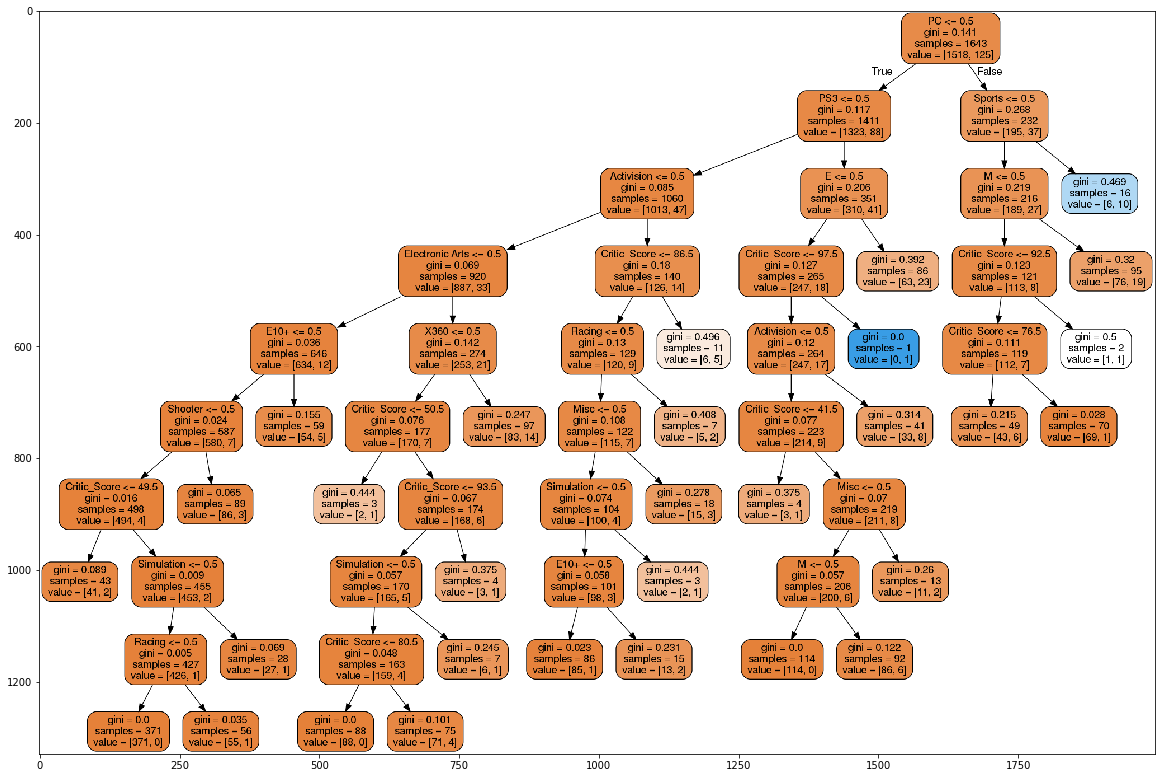

In [12]:
show_tree(dt12, features, 'arbol_normal.png')

Árbol Oversampled:

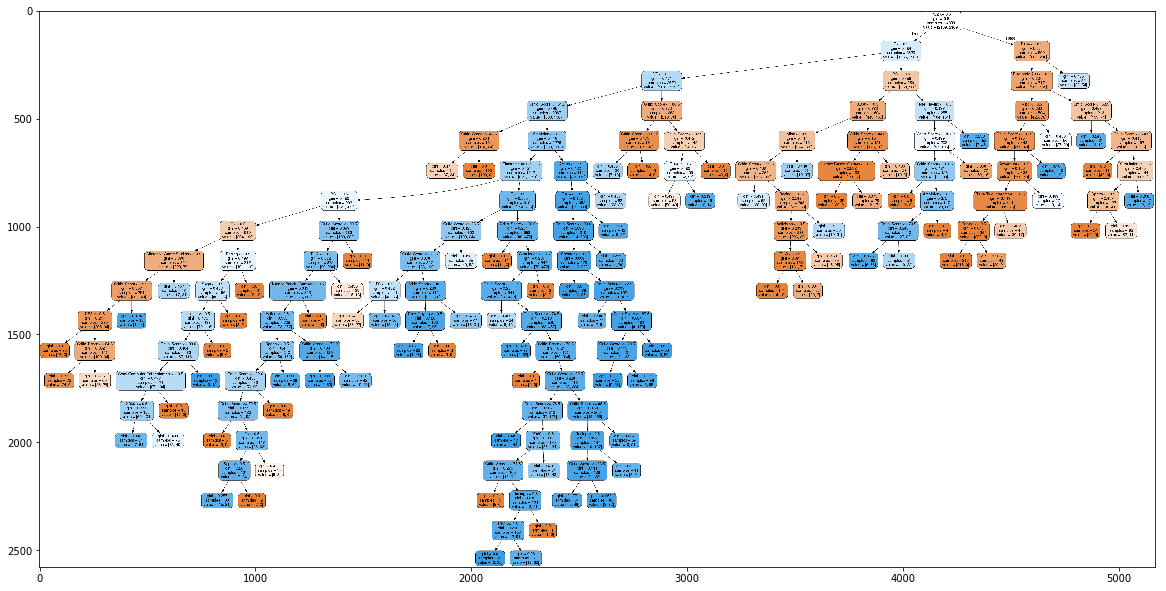

In [13]:
show_tree(dt13, features, 'arbol_oversampled.png')

Árbol Subsampled:

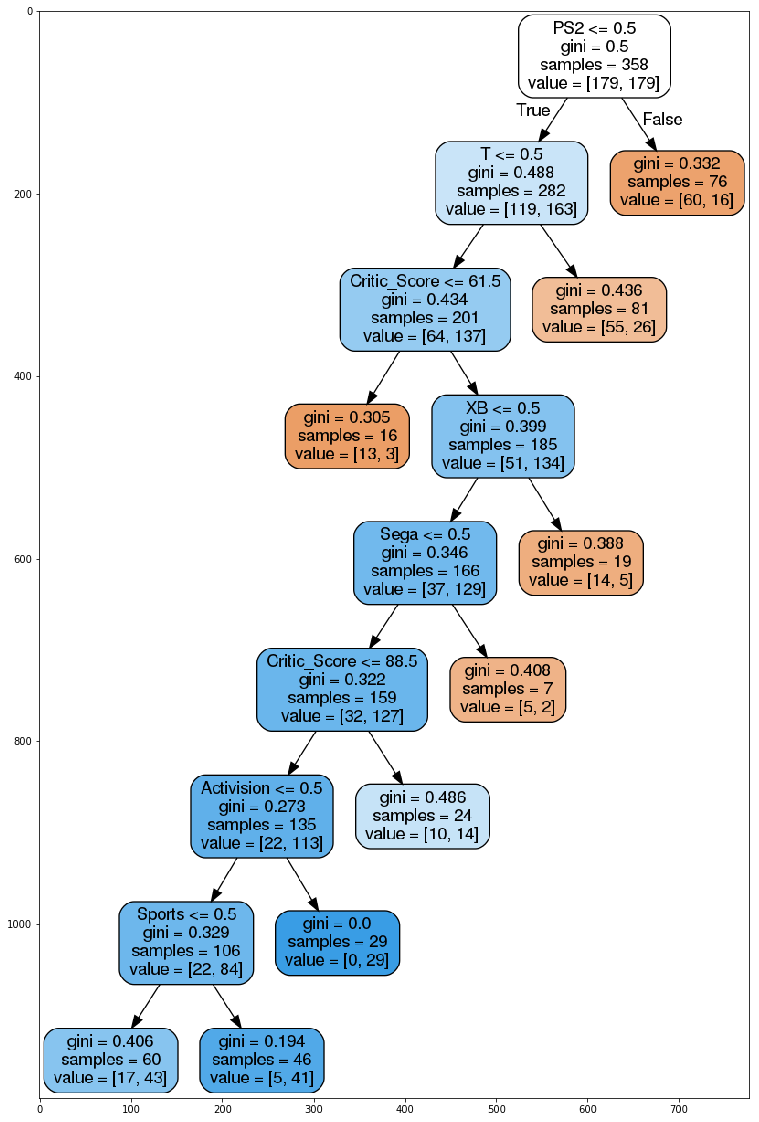

In [14]:
show_tree(dt14, features, 'arbol_subsampled.png')

Árbol con Oversampling y Subsampling:

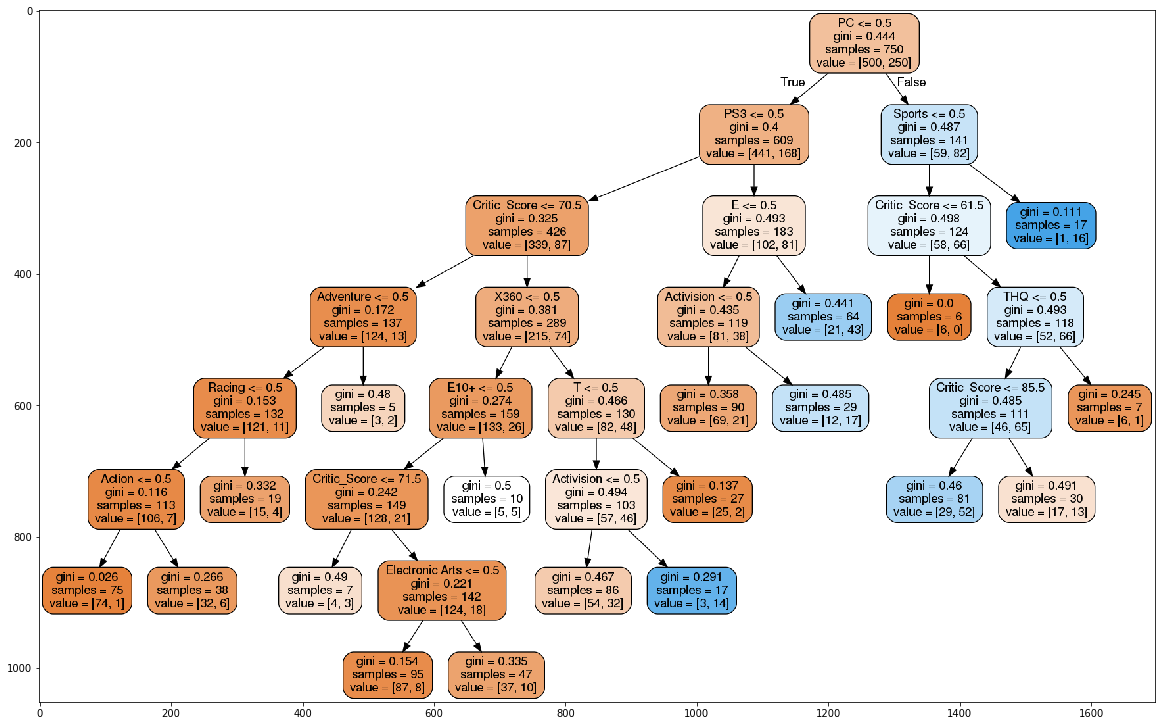

In [15]:
show_tree(dt15, features, 'arbol_master.png')

# 6 - Random Forest
Se aplica Random Forest para obtener los atributos que tienen mayor importancia en los árboles de decisión.

In [16]:

clf6 = RandomForestClassifier(n_estimators= 1000,max_depth=100, random_state=0)
train, test= train_test_split(new_data,test_size=.30, stratify=y)

        
X_train= train[features]
y_train=train["Is_Fiasco"]

X_test=test[features]
y_test=test["Is_Fiasco"]
clf6.fit(X_train, y_train)
import operator
mi_lista_de_tuplas = []
for i in range(33):
    tupla = (header[i],clf6.feature_importances_[i])
    mi_lista_de_tuplas.append(tupla)
mi_lista_de_tuplas.sort(key=operator.itemgetter(1), reverse=True)
for i in range(33):
    print(mi_lista_de_tuplas[i])

('Critic_Score', 0.5041611821613888)
('PC', 0.036322375435558635)
('Activision', 0.03584665886884746)
('Electronic Arts', 0.030481592699049837)
('PS3', 0.028154821225072006)
('E', 0.02595636773957999)
('Sports', 0.024909198877063755)
('T', 0.023982438859708705)
('Action', 0.02282381364867099)
('X360', 0.021048733132245097)
('PS2', 0.02010930224697835)
('E10+', 0.0189982529813256)
('XB', 0.018936733107182437)
('M', 0.018434294971528625)
('Take-Two Interactive', 0.01716735697233548)
('Racing', 0.015154815130337257)
('Shooter', 0.014979658232451648)
('Role-Playing', 0.014497485487028526)
('Ubisoft', 0.01274516338293409)
('Sega', 0.011244140493602587)
('Misc', 0.01119589883505557)
('Simulation', 0.010786919083023387)
('Sony Computer Entertainment', 0.010074063722369355)
('Microsoft Game Studios', 0.009771325291282409)
('THQ', 0.009479451773088236)
('Platform', 0.008757552225753605)
('Strategy', 0.007084876467165853)
('Konami Digital Entertainment', 0.006222611425717568)
('Namco Bandai Game